In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/Dataset" "/content/"


In [ ]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 32.3 MB/s eta 0:00:00


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.9 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade transformers


In [ ]:
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.6 MB/s eta 0:00:00


FOLD 1
Epoch [1/10] | Train Loss: 0.0235 | Train Accuracy: 0.5278 | Val Loss: 0.0220 | Val Accuracy: 0.7429 | Train Precision: 0.5280 | Train Recall: 0.5279 | Train F1: 0.5279 | Val Precision: 0.7427 | Val Recall: 0.7429 | Val F1: 0.7428
Epoch [2/10] | Train Loss: 0.0215 | Train Accuracy: 0.5732 | Val Loss: 0.0210 | Val Accuracy: 0.7667 | Train Precision: 0.5734 | Train Recall: 0.5730 | Train F1: 0.5732 | Val Precision: 0.7912 | Val Recall: 0.7707 | Val F1: 0.7808
Epoch [3/10] | Train Loss: 0.0199 | Train Accuracy: 0.6742 | Val Loss: 0.0201 | Val Accuracy: 0.6952 | Train Precision: 0.6744 | Train Recall: 0.6743 | Train F1: 0.6744 | Val Precision: 0.7143 | Val Recall: 0.6906 | Val F1: 0.7023
Epoch [4/10] | Train Loss: 0.0186 | Train Accuracy: 0.6969 | Val Loss: 0.0193 | Val Accuracy: 0.7238 | Train Precision: 0.6970 | Train Recall: 0.6970 | Train F1: 0.6970 | Val Precision: 0.7337 | Val Recall: 0.7206 | Val F1: 0.7271
Epoch [5/10] | Train Loss: 0.0169 | Train Accuracy: 0.7684 | Val Loss

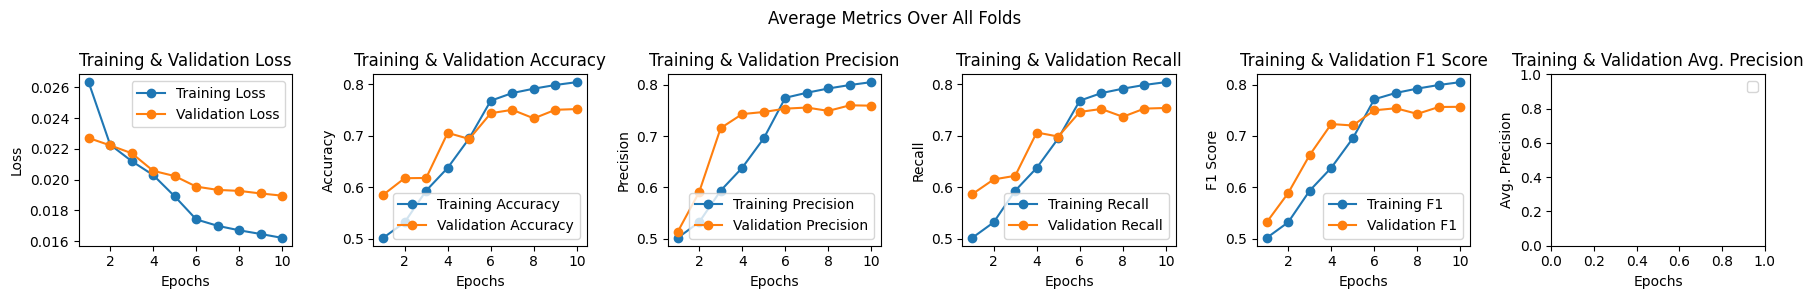

In [ ]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import (ToTensor, Resize, RandomResizedCrop, RandomRotation,
                                   RandomHorizontalFlip, RandomVerticalFlip, ColorJitter)
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, random_split, Subset
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR

!cp -r "/content/drive/MyDrive/combined_dataset" "/content/combined_dataset"

data_dir = '/content/combined_dataset'
image_size = (224, 224)
batch_size = 32
num_epochs = 10
num_folds = 10

train_transform = torchvision.transforms.Compose([
    RandomResizedCrop(image_size),
    RandomRotation(15),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ToTensor()
])

val_test_transform = torchvision.transforms.Compose([
    Resize(image_size, antialias=True),
    ToTensor()
])

full_dataset = ImageFolder(data_dir, transform=train_transform)
num_classes = len(full_dataset.classes)

train_size = int(0.7 * len(full_dataset))
validation_size = (len(full_dataset) - train_size) // 2
test_size = len(full_dataset) - train_size - validation_size
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, validation_size, test_size])

validation_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_results = []


class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 56 * 56, 512),  # 56x56 is the size after two max pooling operations on a 224x224 image
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


for fold, (train_ids, _) in enumerate(kfold.split(train_dataset)):
    print(f"FOLD {fold + 1}")

    train_subsampler = Subset(train_dataset, train_ids)
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    model = DeepCNN(num_classes=num_classes)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    model.to(device)

    train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []
    train_prec_list, train_recall_list, train_f1_list = [], [], []
    val_prec_list, val_recall_list, val_f1_list = [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        TP = np.zeros(num_classes)
        FP = np.zeros(num_classes)
        FN = np.zeros(num_classes)

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            train_correct += (preds == labels).sum().item()

            # Update TP, FP, FN values
            for i in range(num_classes):
                TP[i] += ((preds == i) & (labels == i)).sum().item()
                FP[i] += ((preds == i) & (labels != i)).sum().item()
                FN[i] += ((preds != i) & (labels == i)).sum().item()

        scheduler.step()
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_accuracy = train_correct / len(train_loader.dataset)

        train_precision = np.mean([TP[i] / (TP[i] + FP[i]) if TP[i] + FP[i] != 0 else 0 for i in range(num_classes)])
        train_recall = np.mean([TP[i] / (TP[i] + FN[i]) if TP[i] + FN[i] != 0 else 0 for i in range(num_classes)])
        train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall) if train_precision + train_recall != 0 else 0

        model.eval()
        val_loss, val_correct = 0.0, 0

        TP = np.zeros(num_classes)
        FP = np.zeros(num_classes)
        FN = np.zeros(num_classes)

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()

                # Update TP, FP, FN values
                for i in range(num_classes):
                    TP[i] += ((preds == i) & (labels == i)).sum().item()
                    FP[i] += ((preds == i) & (labels != i)).sum().item()
                    FN[i] += ((preds != i) & (labels == i)).sum().item()

        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_accuracy = val_correct / len(val_loader.dataset)

        val_precision = np.mean([TP[i] / (TP[i] + FP[i]) if TP[i] + FP[i] != 0 else 0 for i in range(num_classes)])
        val_recall = np.mean([TP[i] / (TP[i] + FN[i]) if TP[i] + FN[i] != 0 else 0 for i in range(num_classes)])
        val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall) if val_precision + val_recall != 0 else 0

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Train Accuracy: {avg_train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Accuracy: {avg_val_accuracy:.4f} | "
              f"Train Precision: {train_precision:.4f} | "
              f"Train Recall: {train_recall:.4f} | "
              f"Train F1: {train_f1:.4f} | "
              f"Val Precision: {val_precision:.4f} | "
              f"Val Recall: {val_recall:.4f} | "
              f"Val F1: {val_f1:.4f}")

        # Append results to respective lists
        train_acc_list.append(avg_train_accuracy)
        train_loss_list.append(avg_train_loss)
        train_prec_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1)
        val_acc_list.append(avg_val_accuracy)
        val_loss_list.append(avg_val_loss)
        val_prec_list.append(val_precision)
        val_recall_list.append(val_recall)
        val_f1_list.append(val_f1)

    fold_results.append({
        'train_acc': train_acc_list,
        'train_loss': train_loss_list,
        'train_prec': train_prec_list,
        'train_recall': train_recall_list,
        'train_f1': train_f1_list,
        'val_acc': val_acc_list,
        'val_loss': val_loss_list,
        'val_prec': val_prec_list,
        'val_recall': val_recall_list,
        'val_f1': val_f1_list
    })

# Save all results
torch.save(fold_results, 'fold_results.pth')
# Plotting function
# Updated plotting function
# Compute average metrics over all folds
# Save all results
torch.save(fold_results, 'fold_results.pth')

# Compute average metrics over all folds
avg_metrics = {
    'train_acc': np.mean([result['train_acc'] for result in fold_results], axis=0),
    'train_loss': np.mean([result['train_loss'] for result in fold_results], axis=0),
    'train_prec': np.mean([result['train_prec'] for result in fold_results], axis=0),
    'train_recall': np.mean([result['train_recall'] for result in fold_results], axis=0),
    'train_f1': np.mean([result['train_f1'] for result in fold_results], axis=0),
    'val_acc': np.mean([result['val_acc'] for result in fold_results], axis=0),
    'val_loss': np.mean([result['val_loss'] for result in fold_results], axis=0),
    'val_prec': np.mean([result['val_prec'] for result in fold_results], axis=0),
    'val_recall': np.mean([result['val_recall'] for result in fold_results], axis=0),
    'val_f1': np.mean([result['val_f1'] for result in fold_results], axis=0)
}

# Plotting function
def plot_metrics(metrics, title):
    plt.figure(figsize=(18, 3))
    epochs = range(1, num_epochs + 1)

    plt.subplot(1, 6, 1)
    plt.plot(epochs, metrics['train_loss'], '-o', label='Training Loss')
    plt.plot(epochs, metrics['val_loss'], '-o', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 6, 2)
    plt.plot(epochs, metrics['train_acc'], '-o', label='Training Accuracy')
    plt.plot(epochs, metrics['val_acc'], '-o', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 6, 3)
    plt.plot(epochs, metrics['train_prec'], '-o', label='Training Precision')
    plt.plot(epochs, metrics['val_prec'], '-o', label='Validation Precision')
    plt.title('Training & Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(1, 6, 4)
    plt.plot(epochs, metrics['train_recall'], '-o', label='Training Recall')
    plt.plot(epochs, metrics['val_recall'], '-o', label='Validation Recall')
    plt.title('Training & Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(1, 6, 5)
    plt.plot(epochs, metrics['train_f1'], '-o', label='Training F1')
    plt.plot(epochs, metrics['val_f1'], '-o', label='Validation F1')
    plt.title('Training & Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Placeholder for average precision (AP)
    plt.subplot(1, 6, 6)
    plt.title('Training & Validation Avg. Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Avg. Precision')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Now plot average metrics over all folds
plot_metrics(avg_metrics, title="Average Metrics Over All Folds")


import matplotlib.pyplot as plt

# Initialize lists to store values
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    
    # Training code...

    # Calculate train accuracy and append to list
    train_accuracy = train_correct / len(train_dataset)
    train_accuracies.append(train_accuracy)

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    
    # Testing code...
    
    # Calculate test accuracy and append to list
    test_accuracy = test_correct / len(test_dataset)
    test_accuracies.append(test_accuracy)

    # Append train and test losses to lists
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Plotting the tables
epochs = range(1, num_epochs + 1)

# Plot train and test losses
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plot train and test accuracies
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()
